In [40]:

from functools import partial
from itertools import product
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from skbio import DistanceMatrix
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [3]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [ ]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [5]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [6]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

In [7]:
aitchison_prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

In [8]:
def pcoa_amend_axes(transformer, axes_names):
    pe = transformer.ordination_.proportion_explained
    return [f'{axn} ({pexp:.1%})' for pexp, axn in zip(pe, axes_names)]

In [9]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
        'axes': ['PCoA-1', 'PCoA-2'],
        'amend_axes': pcoa_amend_axes,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP,
                            min_dist=1,
                            random_state=724
                            ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2']
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(UMAP,
                            min_dist=1,
                            n_neighbors=80,
                            random_state=825),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2']
    },
]

In [10]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    amend_axes = emb.get('amend_axes', lambda t, labels: labels)
    results[(name, method)] = {'ordination': result,
                               'axes': amend_axes(transformer, emb['axes']),
                               }


In [11]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}

metadata['host_surface'] = metadata['host_subject_id'] + \
                           metadata['sample_type']


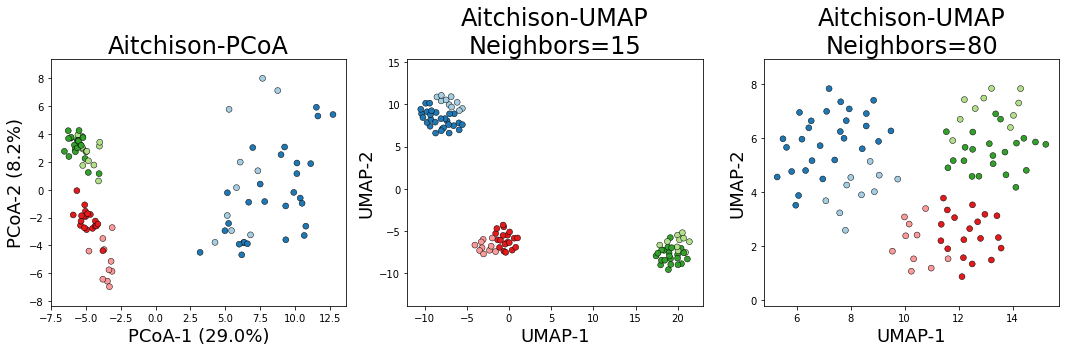

In [12]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 5),
                        )
for (name, method), result in results.items():
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='host_surface',
            hue_order=list(sorted(metadata['host_surface'].unique())),
            # style='sample_type',
            data=res,
            ax=axs[j],
            s=35,
            edgecolor='k',
            palette='Paired',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18)

plt.tight_layout()
plt.savefig('results/2.0-real-data-keyboard-ordination-aitchison.svg', dpi=300)
plt.show()

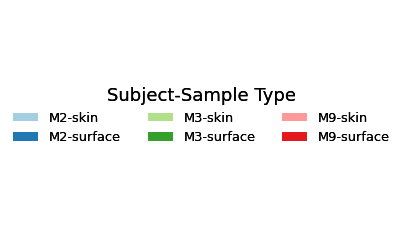

In [13]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []

    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)

    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

fig, ax = plt.subplots()
unique = list(sorted(metadata['host_surface'].unique()))
unique = [u[:2] + '-' + u[2:] for u in unique]

add_legend(ax, 'Paired', unique,
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=3, framealpha=0.0,
               title='Subject-Sample Type',
               title_fontsize=18,
           )
)
ax.axis('off')
plt.savefig('results/2.0-real-data-keyboard-ordination-legend.svg')
plt.show()

array([[-0.11820307,  0.57494411, -0.11820307, ..., -0.11820307,
         1.26809129, -0.11820307],
       [-0.04194283, -0.04194283,  0.65120435, ..., -0.04194283,
         2.35595245, -0.04194283],
       [-0.09991859, -0.09991859,  0.59322859, ..., -0.09991859,
         2.2026665 , -0.09991859],
       ...,
       [-0.03409787, -0.03409787, -0.03409787, ..., -0.03409787,
         1.57534004, -0.03409787],
       [-0.03503198, -0.03503198, -0.03503198, ..., -0.03503198,
         1.35126238, -0.03503198],
       [-0.05815695, -0.05815695, -0.05815695, ..., -0.05815695,
         2.4267497 , -0.05815695]])

In [27]:
clr_coordinates = aitchison_pipeline.fit_transform(table)
distances = cdist(clr_coordinates, clr_coordinates)
adm = DistanceMatrix(
    distances ,
    ids=metadata.index,
)

In [29]:
m2_ids = metadata[metadata.host_subject_id == 'M2'].index
m3_ids = metadata[metadata.host_subject_id == 'M3'].index
m9_ids = metadata[metadata.host_subject_id == 'M9'].index
m2m3 = adm.between(m2_ids, m3_ids)
m2m9 = adm.between(m2_ids, m9_ids)
m3m9 = adm.between(m3_ids, m9_ids)

In [41]:
def ci(dist):
    return dist.mean(), 1.96 * dist.std() / np.sqrt(len(dist))

In [42]:
ci(m2m3)

(value    19.887087
 dtype: float64,
 value    0.106436
 dtype: float64)

In [43]:
ci(m2m9)

(value    18.942012
 dtype: float64,
 value    0.120493
 dtype: float64)

In [44]:
ci(m3m9)

(value    13.867013
 dtype: float64,
 value    0.111524
 dtype: float64)

In [14]:
def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [15]:
repeat_embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
]

for i in range(10):
    new_methods = [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
    ]
    repeat_embedding_methods.extend(new_methods)

In [16]:
repeat_results = dict()

for i, (prep, emb) in enumerate(product(aitchison_prep_tables,
                                repeat_embedding_methods)):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    repeat_results[(i, name, method)] = {'ordination': result}

In [17]:
model = LinearDiscriminantAnalysis()

for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    grouping = metadata['host_subject_id']
    model.fit(first_pcs, grouping)
    stats_result = model.score(first_pcs, grouping)

    result_key = 'within_subject_clustering_model'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        model.fit(sub_pcs, sub_target)
        stats_result = model.score(sub_pcs, sub_target)
        result[result_key][subject] = stats_result

for (i, name, method), result in repeat_results.items():
    result['model statistics'] = dict()
    result['model statistics']['host'] = \
        result['within_subject_clustering_model']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_model'][subject]
        result['model statistics'][f'{subject}-type'] = stat

model_statistics = dict()
for (i, name, method), result in repeat_results.items():
    model_statistics[(i, name, method)] = result['model statistics']

In [18]:
pd.DataFrame(model_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)


host      M2-type        M3-type        M9-type  \
                             mean  std    mean    std    mean    std    mean   
level_1   level_2                                                              
Aitchison PCoA               0.99  NaN   0.789    NaN   0.781    NaN   0.931   
          UMAP Neighbors=15  1.00  0.0   0.974  0.012   0.856  0.049   0.990   
          UMAP Neighbors=80  1.00  0.0   0.992  0.013   0.831  0.059   0.969   

                                    
                               std  
level_1   level_2                   
Aitchison PCoA                 NaN  
          UMAP Neighbors=15  0.017  
          UMAP Neighbors=80  0.025